In [23]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy.stats import t, norm # For VaR calculation

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [18, 10]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

data_path = '/home/code/Repos/financial_models/bank_nifty_intraday.csv'
print(f"Data path: {data_path}")

Data path: /home/code/Repos/financial_models/bank_nifty_intraday.csv


In [24]:
# Cell 2: Data Loading and Preprocessing
print("--- Data Loading and Preprocessing ---")

try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"Error: File not found at {data_path}.")
    raise

df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')
df = df.set_index('DateTime').sort_index()
if 'Instrument' in df.columns:
    df = df.drop(columns=['Instrument'])
    
resample_freq = '15T'
resampled_df = df['Close'].resample(resample_freq).last().dropna()
log_returns = np.log(resampled_df / resampled_df.shift(1)).dropna()

print("Log returns calculated.")
print(log_returns.head())
print(f"Total log return data points: {len(log_returns)}")

--- Data Loading and Preprocessing ---
Log returns calculated.
DateTime
2015-01-09 09:30:00   -0.002317
2015-01-09 09:45:00    0.001666
2015-01-09 10:00:00   -0.001157
2015-01-09 10:15:00    0.001163
2015-01-09 10:30:00   -0.002076
Name: Close, dtype: float64
Total log return data points: 56770


In [25]:
# Cell 3: Data Splitting (Training and Testing)
print("--- Data Splitting ---")

# Define split point: last ~3 months for testing
# Based on the data ending March 22, 2024, let's use all of 2024 up to available data for testing.
split_date = '2024-01-01'

train_returns = log_returns.loc[log_returns.index < split_date]
test_returns = log_returns.loc[log_returns.index >= split_date]

print(f"Train set size: {len(train_returns)} (up to {train_returns.index[-1]})")
print(f"Test set size: {len(test_returns)} (from {test_returns.index[0]} to {test_returns.index[-1]})")

--- Data Splitting ---
Train set size: 55316 (up to 2023-12-29 15:15:00)
Test set size: 1454 (from 2024-01-01 09:15:00 to 2024-03-22 14:30:00)


--- EDA for Training Data ---


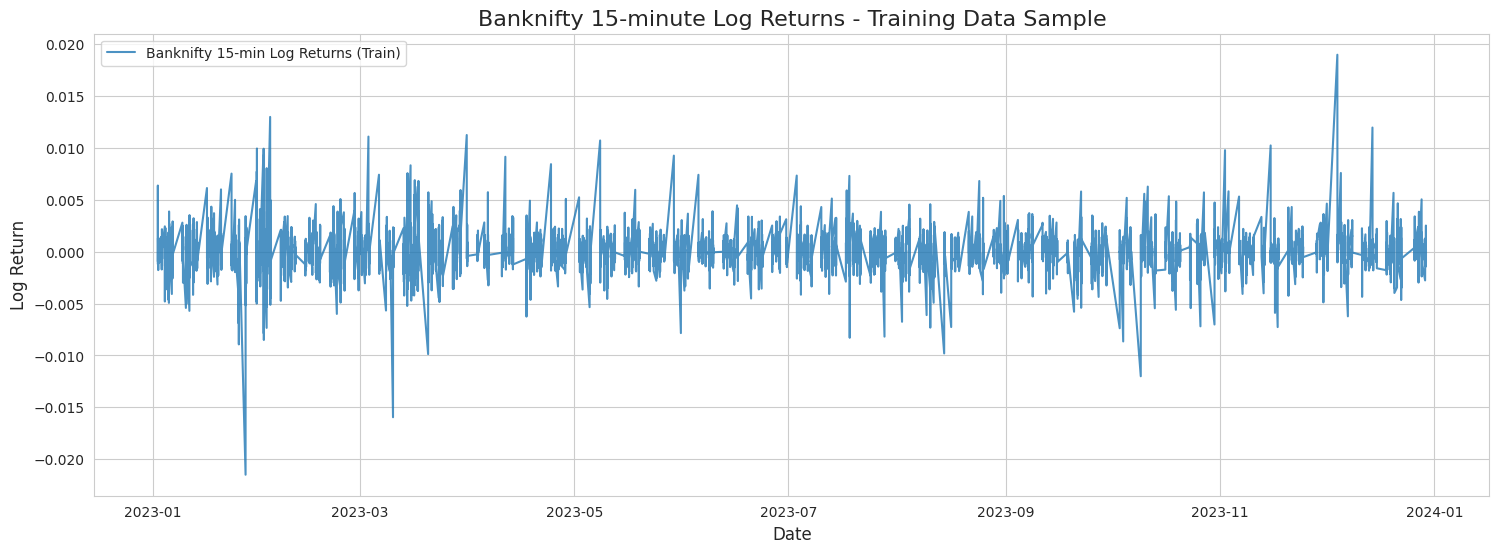

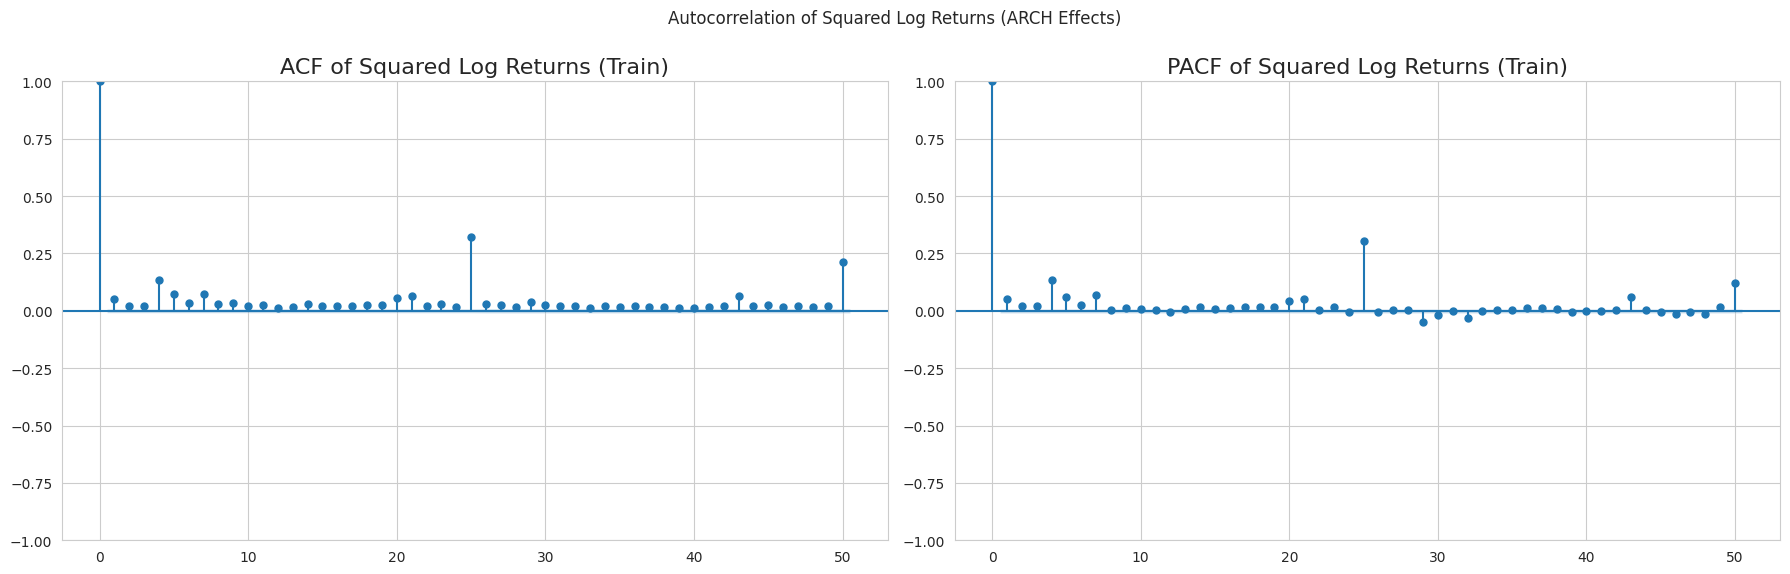

ACF/PACF of squared returns show significant autocorrelation, indicating ARCH effects.
Train returns skewness: -2.7289
Train returns kurtosis: 155.3074


In [26]:
# Cell 4: EDA for Training Data
print("--- EDA for Training Data ---")

plt.figure(figsize=(18, 6))
plt.plot(train_returns.loc['2023-01-01':], label='Banknifty 15-min Log Returns (Train)', alpha=0.8)
plt.title('Banknifty 15-minute Log Returns - Training Data Sample')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plot_acf(train_returns**2, lags=50, ax=axes[0], title='ACF of Squared Log Returns (Train)')
plot_pacf(train_returns**2, lags=50, ax=axes[1], title='PACF of Squared Log Returns (Train)')
plt.suptitle('Autocorrelation of Squared Log Returns (ARCH Effects)')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print("ACF/PACF of squared returns show significant autocorrelation, indicating ARCH effects.")
print(f"Train returns skewness: {train_returns.skew():.4f}")
print(f"Train returns kurtosis: {train_returns.kurtosis():.4f}")

In [27]:
# Cell 5: GARCH Model Fitting (on Training Data)
print("--- GARCH Model Fitting on Training Data ---")

scaled_train_returns = train_returns * 100

model = arch_model(scaled_train_returns, mean='Constant', vol='Garch', p=1, q=1, dist='t')
results = model.fit(disp='off') 

print(results.summary())

# Extract key parameters from the fit on training data
fitted_mu = results.params['mu'] / 100 # Scale back mean
fitted_nu = results.params['nu'] if 'nu' in results.params else None

print("\n--- Interpreted Parameters ---")
print(f"Fitted mu: {fitted_mu:.6f}")
print(f"Fitted omega: {results.params['omega']:.6f}")
print(f"Fitted alpha[1]: {results.params['alpha[1]']:.6f}")
print(f"Fitted beta[1]: {results.params['beta[1]']:.6f}")
if fitted_nu is not None:
    print(f"Fitted nu: {fitted_nu:.4f}")

sum_alpha_beta = results.params['alpha[1]'] + results.params['beta[1]']
print(f"Sum of Alpha + Beta: {sum_alpha_beta:.6f}")
if sum_alpha_beta >= 1:
    print("WARNING: Alpha + Beta >= 1 (high persistence).")
else:
    print("Alpha + Beta < 1 (stationarity in variance).")

--- GARCH Model Fitting on Training Data ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                14029.5
Distribution:      Standardized Student's t   AIC:                          -28048.9
Method:                  Maximum Likelihood   BIC:                          -28004.3
                                              No. Observations:                55316
Date:                      Thu, May 22 2025   Df Residuals:                    55315
Time:                              22:49:01   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

--- GARCH Model Diagnostics on Training Data ---


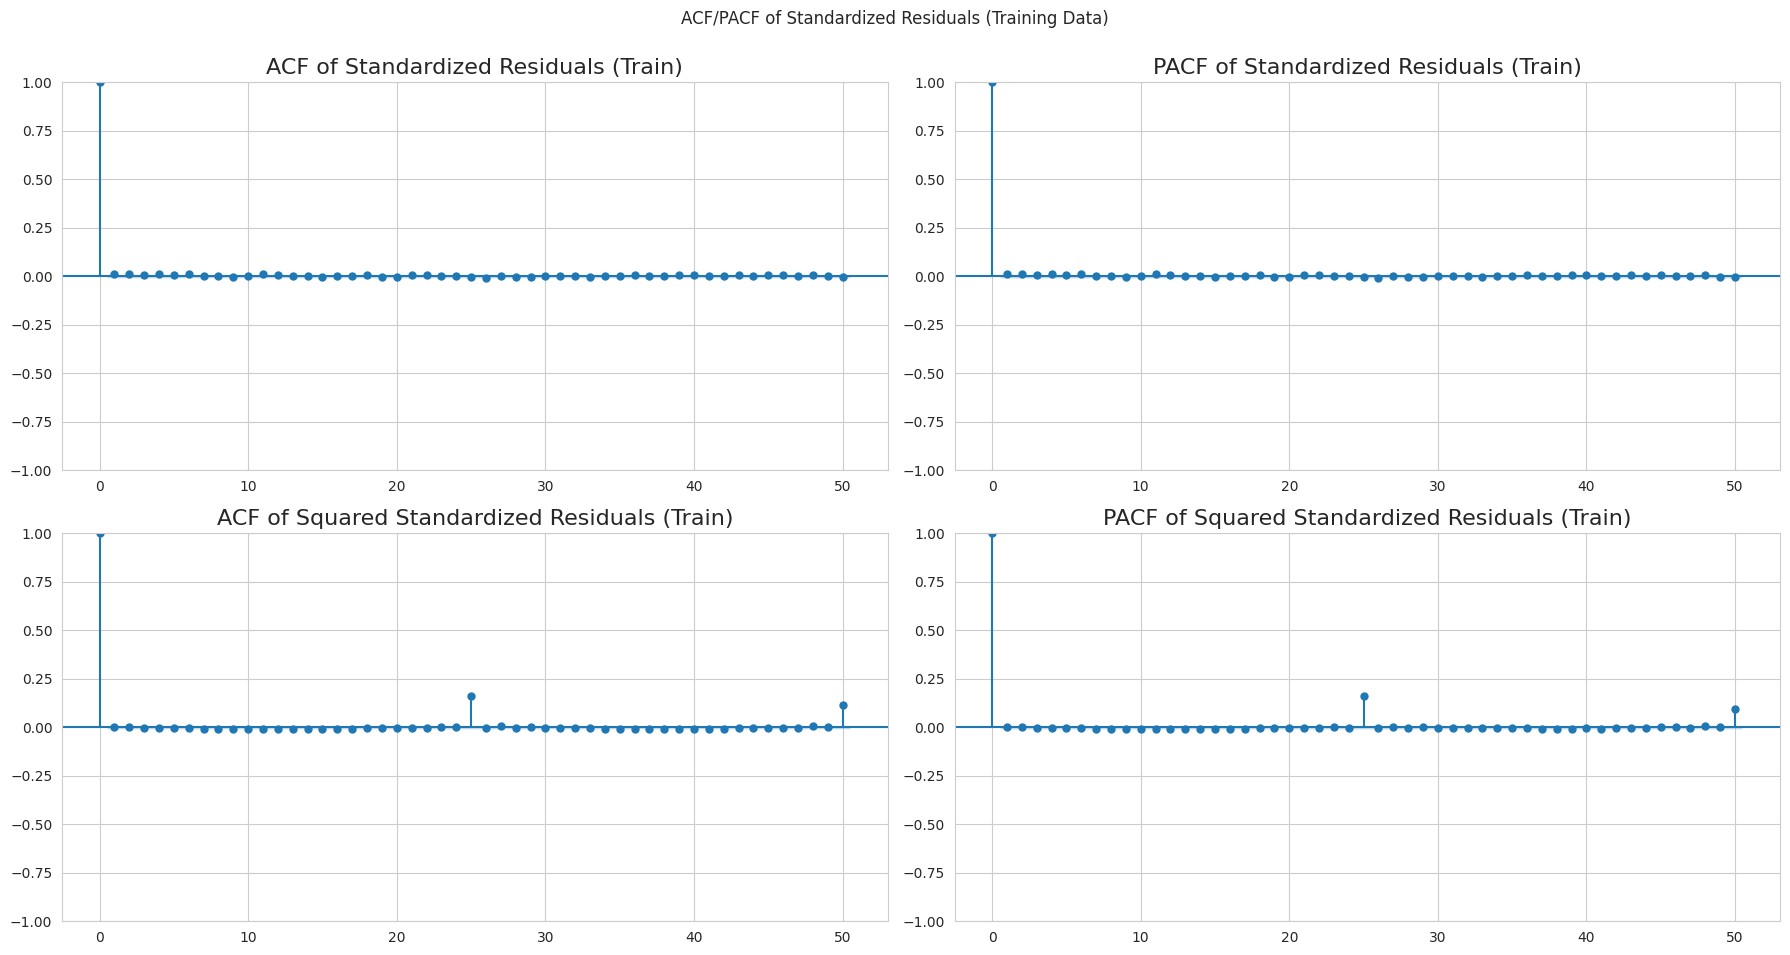

Ideally, no significant autocorrelation should remain in standardized or squared standardized residuals.


In [28]:
# Cell 6: GARCH Model Diagnostics (on Training Data Residuals)
print("--- GARCH Model Diagnostics on Training Data ---")

train_std_resid = results.resid / results.conditional_volatility
train_cond_vol = results.conditional_volatility / 100 # Scale back

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
plot_acf(train_std_resid, lags=50, ax=axes[0, 0], title='ACF of Standardized Residuals (Train)')
plot_pacf(train_std_resid, lags=50, ax=axes[0, 1], title='PACF of Standardized Residuals (Train)')
plot_acf(train_std_resid**2, lags=50, ax=axes[1, 0], title='ACF of Squared Standardized Residuals (Train)')
plot_pacf(train_std_resid**2, lags=50, ax=axes[1, 1], title='PACF of Squared Standardized Residuals (Train)')
plt.suptitle('ACF/PACF of Standardized Residuals (Training Data)')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print("Ideally, no significant autocorrelation should remain in standardized or squared standardized residuals.")

In [29]:
# Cell 7: Predictions (Conditional Volatility) on Test Data
print("--- Predicting Volatility on Test Data ---")

# Forecast conditional volatility and mean for the entire test period
# The 'predict' method gives in-sample conditional volatility if the original data was passed to arch_model.
# For out-of-sample forecasts from the *end of training data*, use results.forecast().
# We want to use the trained model to predict the volatility for the test period
# starting from the last point of training data.
forecast_test_period = results.forecast(horizon=len(test_returns), reindex=True)

# Extract forecasted conditional standard deviation for the test period
# It will be the last row of the variance component, representing the series of horizons.
predicted_test_volatility = np.sqrt(forecast_test_period.variance.iloc[-1]) / 100 # Scale back

# Extract forecasted mean for the test period
# It will be the last row of the mean component.
predicted_test_mean = forecast_test_period.mean.iloc[-1] / 100 # Scale back

# Create a DataFrame for test period predictions
test_prediction_df = pd.DataFrame({
    'Predicted_Volatility': predicted_test_volatility.values, # <--- Add .values here
    'Predicted_Mean': predicted_test_mean.values              # <--- Add .values here
}, index=test_returns.index)

print("Predicted Volatility and Mean for Test Data Head:")
print(test_prediction_df.head())
print("Predicted Volatility and Mean for Test Data Tail:")
print(test_prediction_df.tail())

--- Predicting Volatility on Test Data ---
Predicted Volatility and Mean for Test Data Head:
                     Predicted_Volatility  Predicted_Mean
DateTime                                                 
2024-01-01 09:15:00              0.001758        0.000018
2024-01-01 09:30:00              0.001785        0.000018
2024-01-01 09:45:00              0.001811        0.000018
2024-01-01 10:00:00              0.001836        0.000018
2024-01-01 10:15:00              0.001860        0.000018
Predicted Volatility and Mean for Test Data Tail:
                     Predicted_Volatility  Predicted_Mean
DateTime                                                 
2024-03-22 13:30:00              0.002797        0.000018
2024-03-22 13:45:00              0.002797        0.000018
2024-03-22 14:00:00              0.002797        0.000018
2024-03-22 14:15:00              0.002797        0.000018
2024-03-22 14:30:00              0.002797        0.000018


In [30]:
# Cell 8: VaR Calculation for Test Data
print("--- VaR Calculation for Test Data ---")

confidence_level_percent = 99
alpha = 1 - (confidence_level_percent / 100)

# Get the critical value based on the fitted distribution
if fitted_nu is not None:
    critical_value = t.ppf(alpha, df=fitted_nu)
    print(f"Using Student's t-distribution with {fitted_nu:.2f} degrees of freedom for VaR.")
else:
    critical_value = norm.ppf(alpha)
    print("Using Normal distribution for Z-score (as 'nu' was not available).")

# Calculate VaR for each forecasted period in the test set
# VaR = predicted_mean_return + critical_value * predicted_std_dev
test_prediction_df['Predicted_VaR'] = test_prediction_df['Predicted_Mean'] + critical_value * test_prediction_df['Predicted_Volatility']

print(f"\nPredicted {confidence_level_percent}% VaR for Test Data Head:")
print(test_prediction_df[['Predicted_Volatility', 'Predicted_VaR']].head())
print(f"\nPredicted {confidence_level_percent}% VaR for Test Data Tail:")
print(test_prediction_df[['Predicted_Volatility', 'Predicted_VaR']].tail())

--- VaR Calculation for Test Data ---
Using Student's t-distribution with 4.18 degrees of freedom for VaR.

Predicted 99% VaR for Test Data Head:
                     Predicted_Volatility  Predicted_VaR
DateTime                                                
2024-01-01 09:15:00              0.001758      -0.006419
2024-01-01 09:30:00              0.001785      -0.006517
2024-01-01 09:45:00              0.001811      -0.006611
2024-01-01 10:00:00              0.001836      -0.006702
2024-01-01 10:15:00              0.001860      -0.006790

Predicted 99% VaR for Test Data Tail:
                     Predicted_Volatility  Predicted_VaR
DateTime                                                
2024-03-22 13:30:00              0.002797       -0.01022
2024-03-22 13:45:00              0.002797       -0.01022
2024-03-22 14:00:00              0.002797       -0.01022
2024-03-22 14:15:00              0.002797       -0.01022
2024-03-22 14:30:00              0.002797       -0.01022


In [31]:
# Cell 9: VaR Backtesting and Comparison Metrics
print("--- VaR Backtesting Metrics ---")

# Combine actual test returns with predicted VaR
va_r_comparison_df = pd.DataFrame({
    'Actual_Return': test_returns,
    'Predicted_VaR': test_prediction_df['Predicted_VaR']
}).dropna() # Ensure alignment and no NaNs

num_violations = (va_r_comparison_df['Actual_Return'] < va_r_comparison_df['Predicted_VaR']).sum()
total_comparison_periods = len(va_r_comparison_df)

if total_comparison_periods > 0:
    expected_violations = total_comparison_periods * alpha
    actual_violation_rate = (num_violations / total_comparison_periods) * 100
    expected_violation_rate = alpha * 100

    print(f"\nBacktesting Results for {total_comparison_periods} test periods:")
    print(f"Confidence Level: {confidence_level_percent}% VaR (Alpha: {alpha:.2%})")
    print(f"Expected number of violations: {expected_violations:.2f}")
    print(f"Actual number of violations: {num_violations}")
    print(f"Actual violation rate: {actual_violation_rate:.2f}%")
    print(f"Expected violation rate: {expected_violation_rate:.2f}%")

    if num_violations > expected_violations:
        print("Interpretation: Model is likely UNDERESTIMATING risk (too many violations).")
    elif num_violations < expected_violations:
        print("Interpretation: Model is likely OVERESTIMATING risk (too few violations).")
    else:
        print("Interpretation: Model's violation rate is as expected.")
else:
    print("No test data available for backtesting.")

--- VaR Backtesting Metrics ---

Backtesting Results for 1454 test periods:
Confidence Level: 99% VaR (Alpha: 1.00%)
Expected number of violations: 14.54
Actual number of violations: 2
Actual violation rate: 0.14%
Expected violation rate: 1.00%
Interpretation: Model is likely OVERESTIMATING risk (too few violations).


--- Visualization: Predicted Volatility & VaR for Test Data ---


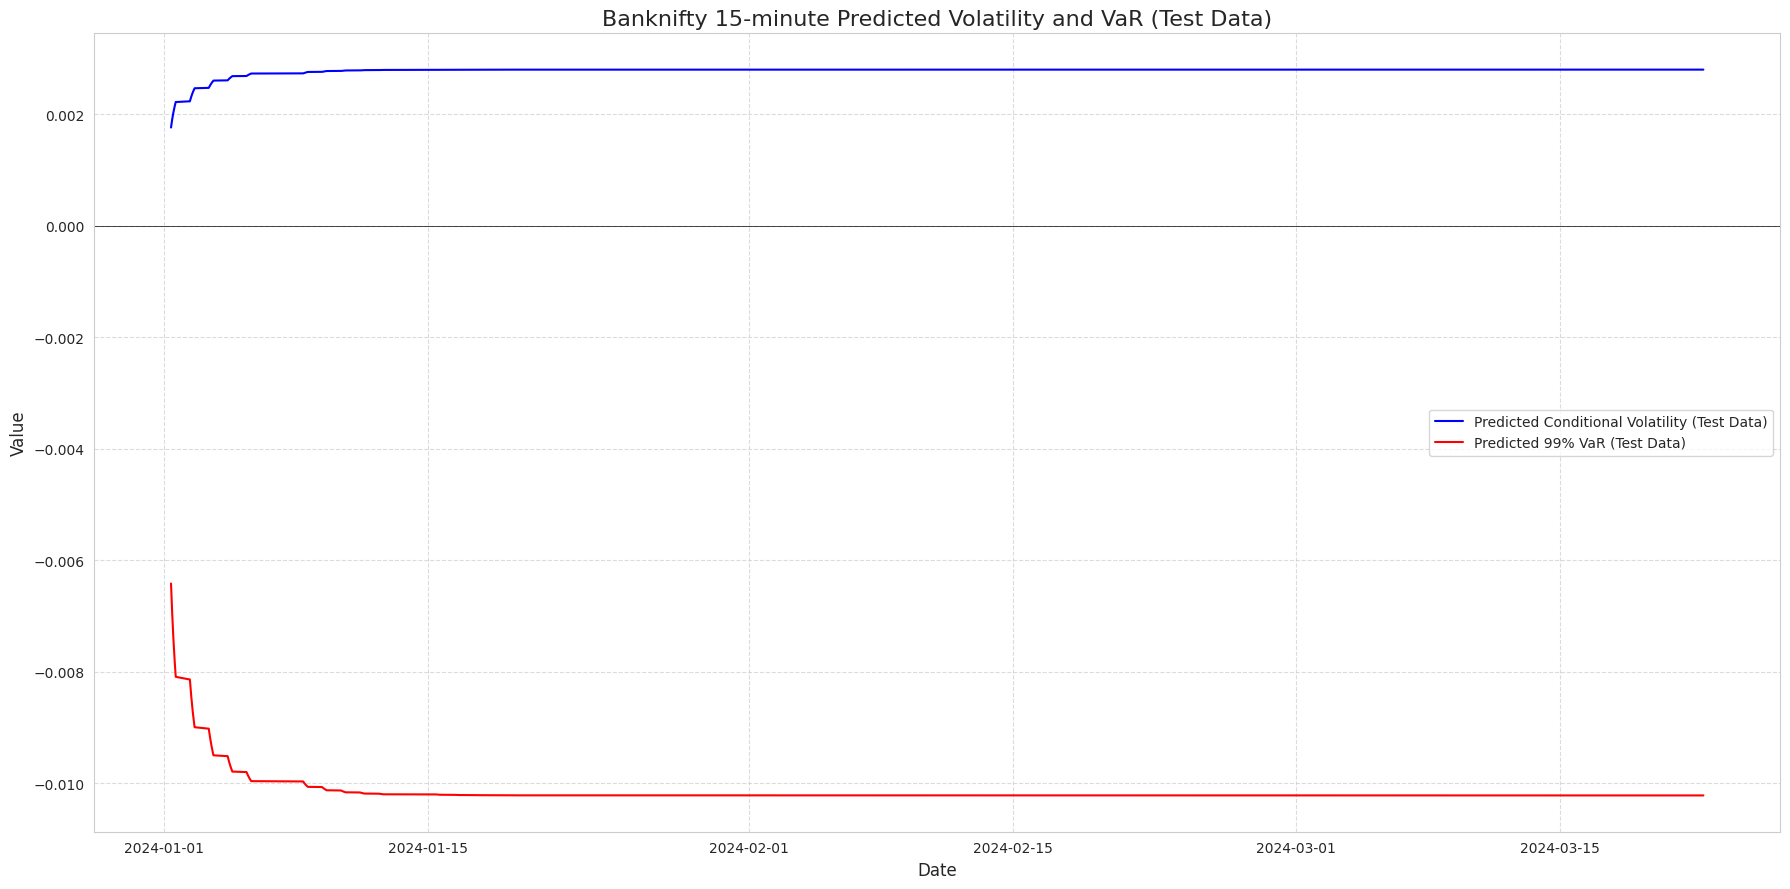

In [32]:
# Cell 10: Visualization 1: Predicted Volatility & VaR for Test Data Only
print("--- Visualization: Predicted Volatility & VaR for Test Data ---")

if test_prediction_df.empty:
    print("No predictions for test data to plot.")
else:
    plt.figure(figsize=(18, 9))
    plt.plot(test_prediction_df.index, test_prediction_df['Predicted_Volatility'], 
             label='Predicted Conditional Volatility (Test Data)', color='blue', linewidth=1.5)
    plt.plot(test_prediction_df.index, test_prediction_df['Predicted_VaR'], 
             label=f'Predicted {confidence_level_percent}% VaR (Test Data)', color='red', linestyle='-', linewidth=1.5)
    
    plt.title('Banknifty 15-minute Predicted Volatility and VaR (Test Data)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()

--- Visualization: Actual Returns (Train & Test) with Predicted VaR (Test) ---


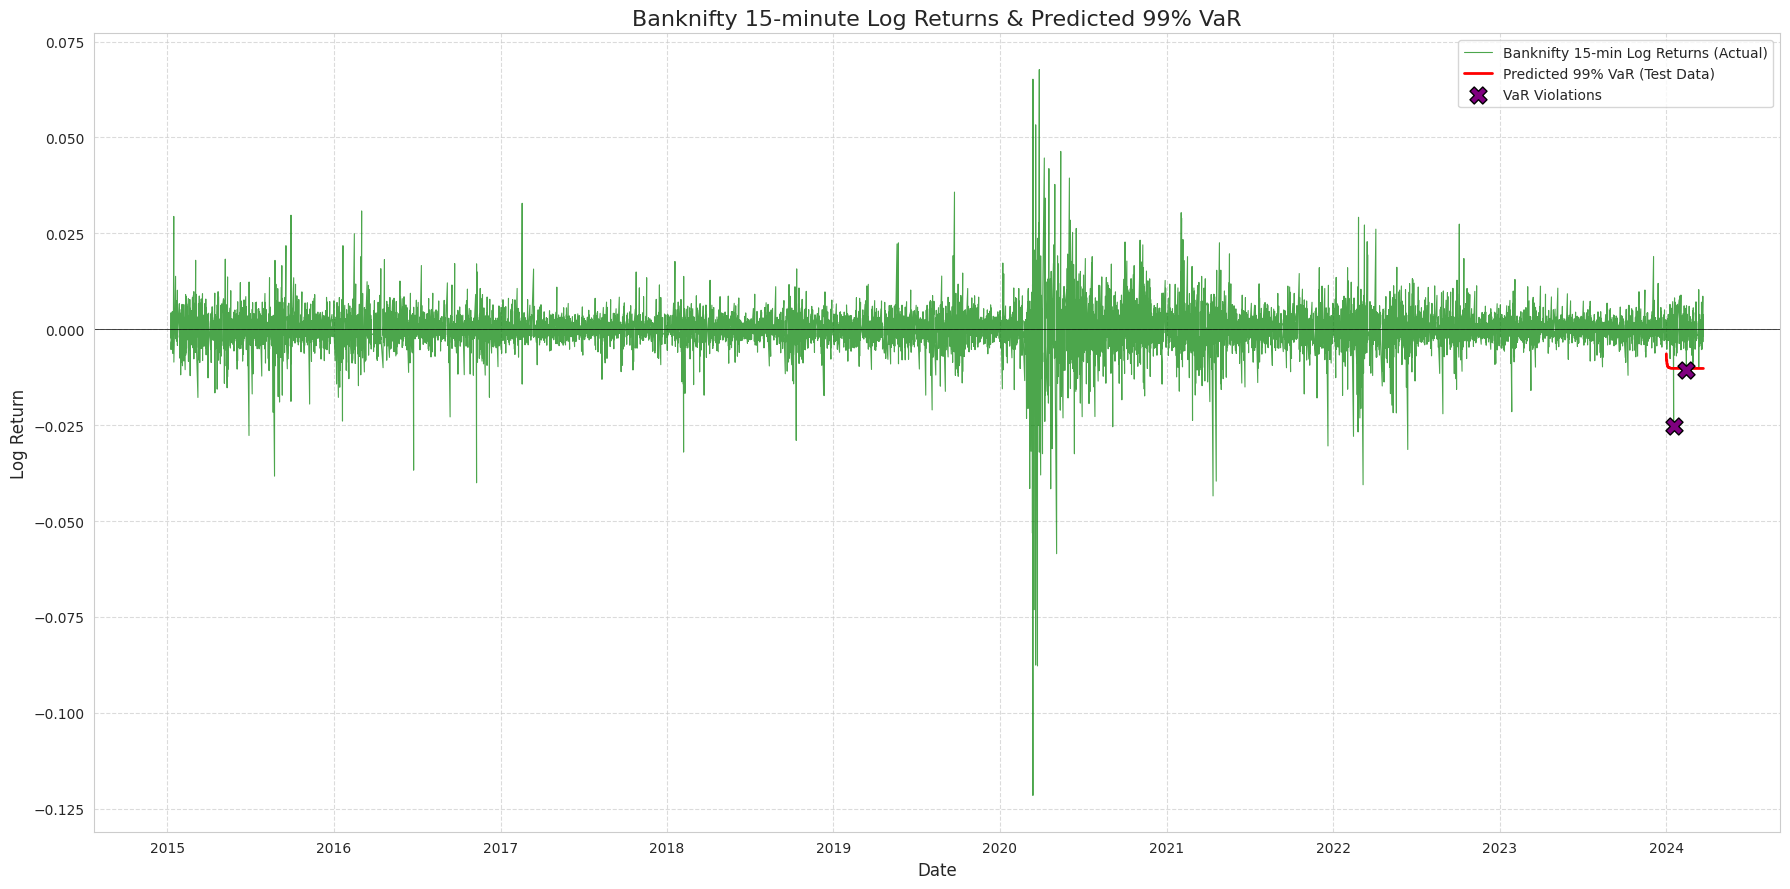


--- GARCH Modeling and VaR Backtesting Pipeline Complete ---


In [33]:
# Cell 11: Visualization 2: Actual Returns (Train & Test) with Predicted VaR (Test)
print("--- Visualization: Actual Returns (Train & Test) with Predicted VaR (Test) ---")

if test_prediction_df.empty:
    print("No predictions for test data to plot alongside actual returns.")
else:
    plt.figure(figsize=(18, 9))

    # Plot full log returns series (train + test)
    plt.plot(log_returns.index, log_returns, 
             label='Banknifty 15-min Log Returns (Actual)', color='green', alpha=0.7, linewidth=0.8)

    # Plot the predicted VaR band for the TEST data only
    plt.plot(test_prediction_df.index, test_prediction_df['Predicted_VaR'],
             color='red', linestyle='-', linewidth=2,
             label=f'Predicted {confidence_level_percent}% VaR (Test Data)')

    # Highlight VaR violations in the test set if available
    if not va_r_comparison_df.empty:
        violations_to_plot = va_r_comparison_df[va_r_comparison_df['Actual_Return'] < va_r_comparison_df['Predicted_VaR']]
        if not violations_to_plot.empty:
            plt.scatter(violations_to_plot.index, violations_to_plot['Actual_Return'],
                        color='purple', marker='X', s=150, zorder=5, edgecolors='black', linewidth=1,
                        label='VaR Violations')

    plt.title(f'Banknifty 15-minute Log Returns & Predicted {confidence_level_percent}% VaR')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()

print("\n--- GARCH Modeling and VaR Backtesting Pipeline Complete ---")